In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import geopandas as gpd


def Load_graph_from_coord(north, south, east, west):
    return ox.graph_from_bbox(north, south, east, west, network_type="drive", simplify=False)
def Load_graph_from_saved(filename):
    return ox.load_graphml(filename)
def Create_road_network(G):
    # create network from that bounding box
    fig, ax = ox.plot_graph(G, node_size = 15, node_color="#1e527e", bgcolor = "white", edge_color="black",edge_linewidth = 2)
    G2 = nx.convert_node_labels_to_integers(G,0)
    G2 = ox.project_graph(G2)

    ID = 1
    l = list(G2.edges)
    for zi in l:
        x,y,z = zi
        G2[x][y][0]["osmid"] = ID 
        G2[x][y][0]["nodes"] = str(x)+"|" + str(y) 
        ID+=1
    return G2
def Create_roads(G2):
    roads  = []

    for edge in G2.edges:
        n1,n2,d = edge

        start = G2.nodes[n1]['x'],-G2.nodes[n1]['y'] 
        end = G2.nodes[n2]['x'],-G2.nodes[n2]['y'] 
        road_params = G2[n1][n2][0]
        
        road = (start,end,road_params)
        roads.append(road)
    return roads




def Load_buildings_from_coord(north, south, east, west):
    return ox.geometries_from_bbox(north, south, east, west, {"building": True})
def Load_buildings_from_saved(filename):
    return gpd.read_file(filename)



def Polygon_refactor(polygon):
    polygon1 = np.array([polygon[0], -np.array(polygon[1])]).T
    return polygon1
def Create_buidings(gdf):
    buildings = []

    gdf_project_poly = ox.project_gdf(gdf)["geometry"]

    for poly in gdf_project_poly[:-1]:
        if (poly.geom_type == 'MultiPolygon'): 
            for ea in poly.geoms:
                buildings.append(Polygon_refactor(ea.exterior.coords.xy))
            
        elif (poly.geom_type == 'Polygon'):
            buildings.append(Polygon_refactor(poly.exterior.coords.xy))
            
    
    
    return  buildings




In [2]:
buildings_path = "data/mybuildings.gpkg"
network_path = "data/mynetwork.graphml"

def SAVE_DATA(north, south, east, west):

    nsew = north, south, east, west
    ox.save_graphml(Load_graph_from_coord(*nsew), filepath=network_path)

    gdf = Load_buildings_from_coord(*nsew).apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
    gdf.to_file(buildings_path, driver="GPKG")

In [3]:
# turn response caching off
ox.settings.use_cache = False

# turn it back on and turn on/off logging to your console
ox.settings.use_cache = True
ox.settings.log_console = False

# define a bounding box in Krsk


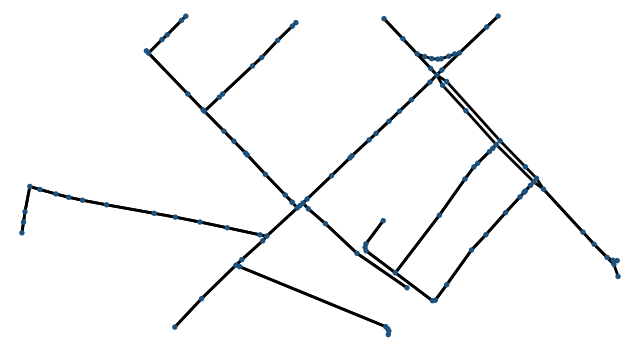

In [4]:


# define a bounding box in Krsk
#north, south, east, west = 56.0438, 56.0321, 92.8749, 92.8594
#north, south, east, west = 56.0476, 56.0171, 92.8346, 92.9000
north, south, east, west =  56.0198, 56.0132, 92.7798, 92.8006

#SAVE_DATA(north, south, east, west)

# buildings = Create_buidings(Load_buildings_from_coord(north, south, east, west))

# # create graph from .osm extract file
# G  = Create_road_network(Load_graph_from_coord(north, south, east, west))
# roads = Create_roads(G)


#SAVE_DATA(north, south, east, west)


buildings = Create_buidings(Load_buildings_from_saved(buildings_path))
G  = Create_road_network(Load_graph_from_saved(network_path))

roads = Create_roads(G)


In [5]:
import threading as thr
def Create_path(G, orig, dest, k = 2, lot_of_paths = []):
    try:
        routes = ox.k_shortest_paths(G, orig, dest, k = k, weight="length")
    except Exception as e:
        return lot_of_paths
    #fig, ax = ox.plot_graph_routes(G, list(routes), route_colors="y", route_linewidth=2, node_size=0)
    else:
        
        L = list(routes)
        for l in L:
            path = []
            for n1,n2 in zip(l[0:], l[1:]):
                path.append(G[n1][n2][0]["osmid"])
            with pool_sema: 
                if len(path): lot_of_paths.append(path)
            


lot_of_paths = []
pool_sema = thr.BoundedSemaphore(value=2)

#origs = [76, 21,  46, 106, 93]
origs = [84,85,66, 21,  46, 96, 93]
origs = [66, 21,  46, 96, 93]
dest = list(G.nodes)
dest = origs
for orig in origs:
    threads = []

    for _ in range(3):
        destp = np.random.choice(dest)
        k = 1

        t = thr.Thread(target=Create_path, args=(G,orig,destp,k,lot_of_paths, ))
        threads.append(t)
        t.start()


In [6]:
PATH = {}
origs = [66, 21,  46, 96, 93, 76]
dest = list(G.nodes)
for orig in origs:
    threads = []
    lot_of_paths = []
    for _ in range(8):
        destp = np.random.choice(dest)
        k = 4

        t = thr.Thread(target=Create_path, args=(G,orig,destp,k,lot_of_paths, ))
        threads.append(t)
        t.start()
    PATH[orig] = lot_of_paths

Exception in thread Thread-41 (Create_path):
Traceback (most recent call last):
  File "c:\python\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\python\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\TimofeyT\AppData\Local\Temp\ipykernel_22932\150924766.py", line 10, in Create_path
  File "c:\python\lib\site-packages\osmnx\distance.py", line 472, in k_shortest_paths
    for path in itertools.islice(paths_gen, 0, k):
  File "c:\python\lib\site-packages\networkx\algorithms\simple_paths.py", line 544, in shortest_simple_paths
    length, path = shortest_path_func(G, source, target, weight=weight)
  File "c:\python\lib\site-packages\networkx\algorithms\simple_paths.py", line 964, in _bidirectional_dijkstra
    raise nx.NetworkXNoPath(f"No path between {source} and {target}.")
networkx.exception.NetworkXNoPath: No path between 46 and 91.


In [7]:
PATH

{66: [[200,
   204,
   210,
   205,
   208,
   16,
   13,
   19,
   33,
   192,
   49,
   45,
   48,
   183,
   181,
   29,
   23,
   28,
   76,
   71],
  [200,
   204,
   210,
   205,
   208,
   16,
   13,
   17,
   31,
   78,
   81,
   190,
   173,
   118,
   114,
   116,
   169,
   171,
   176,
   9,
   4,
   11,
   189],
  [199, 201],
  [200,
   204,
   210,
   205,
   208,
   16,
   13,
   17,
   31,
   78,
   81,
   190,
   173,
   118,
   114,
   116,
   169,
   171,
   176,
   9,
   4,
   11,
   189,
   104,
   107,
   214,
   92,
   90,
   94,
   99,
   96],
  [200,
   204,
   210,
   205,
   208,
   16,
   13,
   17,
   31,
   78,
   81,
   190,
   173,
   118,
   114,
   116,
   169,
   171,
   176,
   9,
   4,
   11,
   189,
   105,
   108,
   163,
   197,
   155,
   151,
   153,
   167,
   161,
   157,
   159,
   102,
   96],
  [200,
   204,
   210,
   205,
   208,
   16,
   13,
   17,
   31,
   78,
   81,
   190,
   173,
   118,
   114,
   116,
   169,
   171,
   176,
   

In [8]:
from trafficsimulation import*
MARLINController = []

def CreateSim(iswindow = False, model_type = None):
    s = Simulation()

    s.create_roads(roads)   
    s.create_buildings(buildings)   


    for file in [
    "data/year_data_av_30_4.xlsx",
    "data/year_data_av_30_5.xlsx",
    "data/year_data_av_30_3.xlsx"
    ]:
        s.create_gen_from_usdc_data_collector(
            file,
            {
            'vehicles':[
                [1, {'path': path}]
                for path in PATH[46]
            ]}
        )

    for file in [
    "data/year_data_av_31_6.xlsx",
    "data/year_data_av_31_7.xlsx"
    ]:
        s.create_gen_from_usdc_data_collector(
            file,
            {
            'vehicles':[
                [1, {'path': path}]
                for path in PATH[66]
            ]}
        )

    for file in [
    "data/year_data_av_61_4.xlsx", "data/year_data_av_61_5.xlsx", "data/year_data_av_61_6.xlsx",
    ]:
        s.create_gen_from_usdc_data_collector(
            file,
            {
            'vehicles':[
                [1, {'path': path}]
                for path in PATH[76]
            ]}
        )


    

    for file in [
    "data/year_data_av_62_1.xlsx","data/year_data_av_62_2.xlsx","data/year_data_av_62_3.xlsx",
    ]:
        s.create_gen_from_usdc_data_collector(
            file,
            {
            'vehicles':[
                [1, {'path': path}]
                for path in PATH[96]
            ]}
        )


    for file in [
    "data/year_data_av_63_8.xlsx","data/year_data_av_63_7.xlsx",
    ]:
        s.create_gen_from_usdc_data_collector(
            file,
            {
            'vehicles':[
                [1, {'path': path}]
                for path in PATH[21]
            ]}
        )
        
    # origs = [66, 21,  46,66,96, 93]
    # for path in (PATH[orig] for orig in origs):
    #     s.create_gen(
    #     {
    #     'vehicle_rate': 400,
    #     'vehicles':[
    #         [1000, {'path': road}]
    #         for road in path
    #     ]}
    #     )





    tl1 = s.create_signal(
        [{208:[0,1]},{41:[0,1,2], 18:[1,2]}, {18:[0]}],
            config = { "cycle":[(True, False, True),(False, True, True),(False, True, False)], "cycle_length": [24,24,24]}
        )

    tl2 = s.create_signal(
            [{176:[0,1,2],122:[0,1,2]},{220:[0,1,2,3,4,5],88:[0,1]}],
            config = {"cycle":[ (True, False),(False, True)], "cycle_length": [60,60]}
        )
        
    # tl3 = s.create_signal(
    #         [{25:[0]},{29:[0]}],
    #         config = {"cycle":[ (True, False),(False, True)]}
    #     )
    #tl2.SwitchNphases(1)
    #MARLINController.append(s.create_control([tl3,]))
    #MARLINController.append(s.create_control([tl2,]))
    # MARLINController.append(s.create_control([tl1,tl2,]))
    #MARLINController.append(s.create_control([tl3]))

    if model_type == "FIXED":
        s.create_control([tl1,],"Fixed")
        s.create_control([tl2,],"Fixed")
    elif model_type == "MARL":
        s.create_control([tl1,],"MARLINController")
        s.create_control([tl2,],"MARLINController")
    elif model_type == "MARLIN":
        s.create_control([tl1,tl2],"MARLINController")
    elif model_type == "FUZZY":
        s.create_control([tl1,tl2],"FLController")
        
    if iswindow :
        offsetx,offsety = roads[0][0]

        # Start simulation
        win = Window(s, config =  {
            "width": 1920,
            "height": 1080,
            "bg_color": (255,255,255),
            "road_color" : (0,0,0),
            "car_color" : (210,210,210),
            "build_color":(30, 82, 126),
            "time_stop": 24*3600
        })
        win.offset = (-offsetx,-offsety)

        win.zoom = 1
        win.run(steps_per_update=2)
    return s

pygame 2.2.0 (SDL 2.0.22, Python 3.10.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [9]:
s1 = CreateSim(True, "MARL")

In [13]:
import threading as thr
from time import sleep

def Run_Experiment(sim, duration, MCOUNT, TOTAL_TIME, MAX_TIME):
    s = deepcopy(sim)
    s.run(duration)

    MCOUNT.append(s.MCOUNT)
    TOTAL_TIME.append(s.TOTAL_TIME)
    MAX_TIME.append(s.MAX_TIME)

for modelname in [ 
    "FIXED",
    # "FUZZY", 
    # "MARL", 
    "MARLIN"]:

    model = CreateSim(False, modelname)
    #model.t = 18*3600

    thread_num = 16
    EXP_NUM = 30
    model.t = 0 # В 17:00
    dur = 24*3600 

    MCOUNT      = []
    TOTAL_TIME  = []
    MAX_TIME    = []




    threads = []
    for x in range(EXP_NUM//thread_num):
        for y in range(thread_num):
            t = thr.Thread(target=Run_Experiment, args=(model, dur, MCOUNT, TOTAL_TIME, MAX_TIME,  ))
            threads.append(t)
            t.start()
    for y in range(EXP_NUM%thread_num):
        t = thr.Thread(target=Run_Experiment, args=(model, dur, MCOUNT, TOTAL_TIME, MAX_TIME,  ))
        threads.append(t)
        t.start()

    while len(TOTAL_TIME) < EXP_NUM: sleep(1)
    
    print(
f"""
{modelname}
{sum(MCOUNT)    / EXP_NUM }
{sum(TOTAL_TIME)/ EXP_NUM}
{sum(MAX_TIME)  / EXP_NUM}
{sum(TOTAL_TIME) / sum(MCOUNT) }
"""
    )   



FIXED
3596.733333333333
53723.306666715405
69.00000000001046
14.93669440790219


MARLIN
3591.5666666666666
33937.440000028386
30.92666666665616
9.449202297983717



In [ ]:
%matplotlib widget
dur = 24 * 3600
s1.t = 0
s1.run(dur)
s = s1

N = len(MARLINController)
fig = plt.figure(figsize=(14,2*N))
fig. tight_layout ()
for i in range(N):
    color = cm.brg(np.linspace(0, 1, len(MARLINController[i].TL)))

    ax = fig.add_subplot(N,1,i+1)
    
    ax.grid(True)
    ax.set_xlabel("steps")
    ax.set_ylabel("Q, sec.")
    for tli in range(len(MARLINController[i].TL)):
        if not(len(MARLINController[i].NB[tli])):
            data = MARLINController[i].data[tli]
            M = len(data)
            max = np.max(data)
            ax.plot(np.linspace(0,M,M),data, color = color[tli],linewidth = 1,label = f"Q{tli+i}")
            ax.axhline(max,color = "red")

        for tlij in range(len(MARLINController[i].NB[tli])-tli):
            data = MARLINController[i].data[tli][tlij]
            M = len(data)
            max = np.max(data)
            ax.plot(np.linspace(0,M,M),data, color = color[tli],linewidth = 1,label = "Q{0},{1}".format(tli+i, MARLINController[i].NB[tli][tlij]+i))
            #ax.axhline(max,color = "red")
    plt.legend(loc = 4)



SystemError: tile cannot extend outside image

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous view', 'arrow-left', 'back'), ('Forward', 'Forward to next view', 'arrow-right', 'forward'), ('Pan', 'Left button pans, Right button zooms\nx/y fixes axis, CTRL fixes aspect', 'arrows', 'pan'), ('Zoom', 'Zoom to rectangle\nx/y fixes axis', 'square-o', 'zoom'), ('Download', 'Download plot', 'floppy-o', 'save_figure')]))

In [ ]:
from trafficsimulation import*

s = Simulation()

s.create_roads(roads)   
s.create_buildings(buildings)   


for file in [
"data/year_data_av_30_4.xlsx",
"data/year_data_av_30_5.xlsx",
"data/year_data_av_30_3.xlsx"
]:
    s.create_gen_from_usdc_data_collector(
        file,
        {
        'vehicles':[
            [1, {'path': path}]
            for path in PATH[46]
        ]}
    )

for file in [
"data/year_data_av_31_6.xlsx",
"data/year_data_av_31_7.xlsx"
]:
    s.create_gen_from_usdc_data_collector(
        file,
        {
        'vehicles':[
            [1, {'path': path}]
            for path in PATH[66]
        ]}
    )

for file in [
"data/year_data_av_32_1.xlsx","data/year_data_av_32_2.xlsx",
]:
    s.create_gen_from_usdc_data_collector(
        file,
        {
        'vehicles':[
            [1, {'path': path}]
            for path in PATH[3]
        ]}
    )
# for path in lot_of_paths:
#     s.create_gen(
#     {
#     'vehicle_rate': 400,
#     'vehicles':[
#         [1, {'path': path}],
#     ]}
    
#     ) 



tl1 = s.create_signal(
      [{208:[0,1]},{41:[0,1,2], 18:[1,2]}, {18:[0]}],
        config = { "cycle":[(True, False, True),(False, True, True),(False, True, False)], "cycle_length": [10,10,10]}
    )

tl2 = s.create_signal(
        [{176:[0,1,2],122:[0,1,2]},{220:[0,1,2,3,4,5],88:[0,1]}],
        config = {"cycle":[ (True, False),(False, True)], "cycle_length": [10,10]}
    )
tl3 = s.create_signal(
        [{25:[0]},{29:[0]}],
        config = {"cycle":[ (True, False),(False, True)], "cycle_length": [10,10]}
    )

s.create_fuzz_control(tl1)
s.create_fuzz_control(tl2)
s.create_fuzz_control(tl3)


offsetx,offsety = roads[0][0]

# Start simulation
win = Window(s, config =  {
       "width": 1920,
       "height": 1080,
       "bg_color": (255,255,255),
       "road_color" : (0,0,0),
       "car_color" : (210,210,210),
       "build_color":(30, 82, 126),
       "time_stop": 24*3600
})
win.offset = (-offsetx,-offsety)

win.zoom = 1
win.run(steps_per_update=2)

KeyError: 3

In [ ]:
time = np.array(control.data)[:,1]
time

In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as fct
from mpl_toolkits.axes_grid1 import make_axes_locatable
ticks = np.linspace(0,24*3600, 24)
labels = [str(int(_x/3600)) for _x in ticks]
margins = {                                                                          
    "left"   : 0.05,
    "bottom" : 0.05,
    "right"  : 0.999,
    "top"    : 0.95 
}
curving_times = 20

BLUE = (0,0,0,0.02)
RED = (0,0,0,0.02)
GREEN = (0,0,0,0.02)
FIGSAVEPATH = "data/"

fig, ax = plt.subplots(figsize=[18,12], tight_layout=True)

fig.subplots_adjust(**{                                                                          
    "left"   : 0.05,
    "bottom" : 0.05,
    "right"  : 0.999,
    "top"    : 0.99 
})  
# house market value

divider = make_axes_locatable(ax )


fig.patch.set_facecolor(RED)

for i in [0,1,2]:
    cax = divider.append_axes("bottom", "-100%", pad="-100%")
    cax.patch.set_facecolor((0,0,0,0))
    cax.set_xticks(ticks)
    cax.set_xticklabels(labels)      
    t = np.array(time[i])
    level_phase_short = fuzz.interp_membership(x_phase_duration, phase_short, t)
    level_phase_med = fuzz.interp_membership(x_phase_duration,phase_med, t)
    level_phase_long = fuzz.interp_membership(x_phase_duration,  phase_long, t)

    short = (level_phase_short >= level_phase_med )& (level_phase_short >= level_phase_long)
    med = (level_phase_med >= level_phase_short ) & (level_phase_med >= level_phase_long)
    long = (level_phase_long >= level_phase_short ) & (level_phase_long >= level_phase_med)


    cax.plot(x_time_of_day, level_phase_short, color = "blue" , label = "короткая")
    cax.fill_between(x_time_of_day, level_phase_short, where = (short), color = (0,0,1,0.2) )
    cax.plot(x_time_of_day, level_phase_med, color = "red" , label = "средняя")
    cax.fill_between(x_time_of_day, level_phase_med, where = (med), color = (1,0,0,0.2) )
    cax.plot(x_time_of_day, level_phase_long, color = "green", label = "длинная" )
    cax.fill_between(x_time_of_day, level_phase_long, where = (long), color = (0,1,0,0.2))

    plt.legend()
ax.remove()

fig.savefig(FIGSAVEPATH + "result.png")